# This is a dataset from the House Prices competition in Kaggle

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Exploratory data

In [38]:
train = pd.read_csv('train.csv')

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [40]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


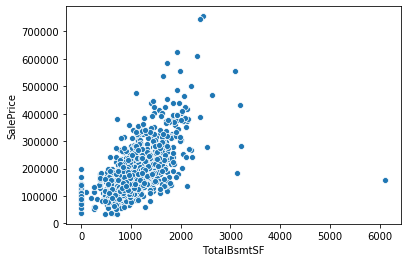

In [41]:
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train)

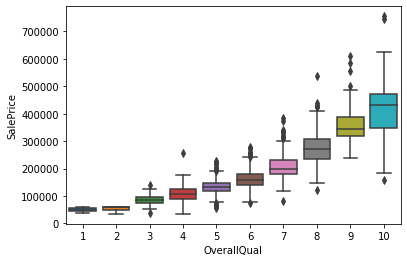

In [42]:
#check the relationship between Overall quality and Sale Price
sns.boxplot(x='OverallQual',y='SalePrice',data=train)

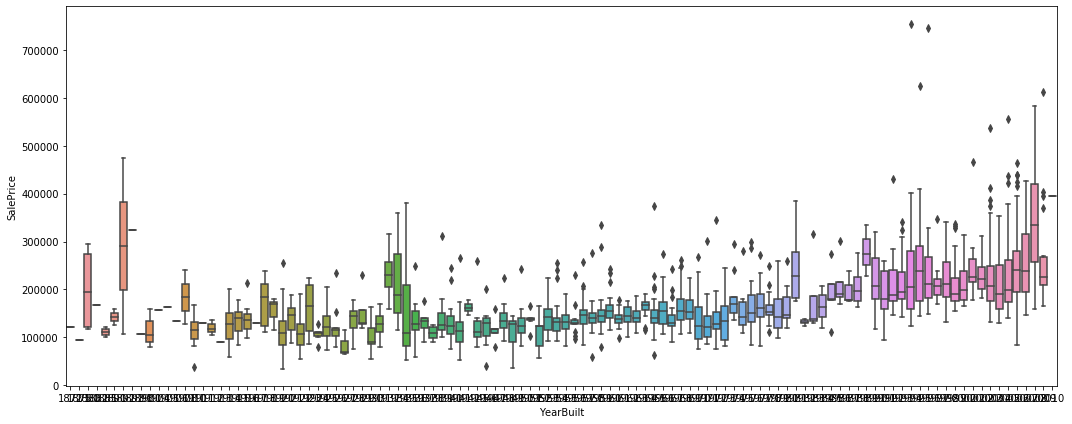

In [43]:
#check the relationship between Construction date of built and Sale price
plt.figure(figsize=(15,6))
sns.boxplot(x='YearBuilt',y='SalePrice',data=train)
plt.tight_layout()

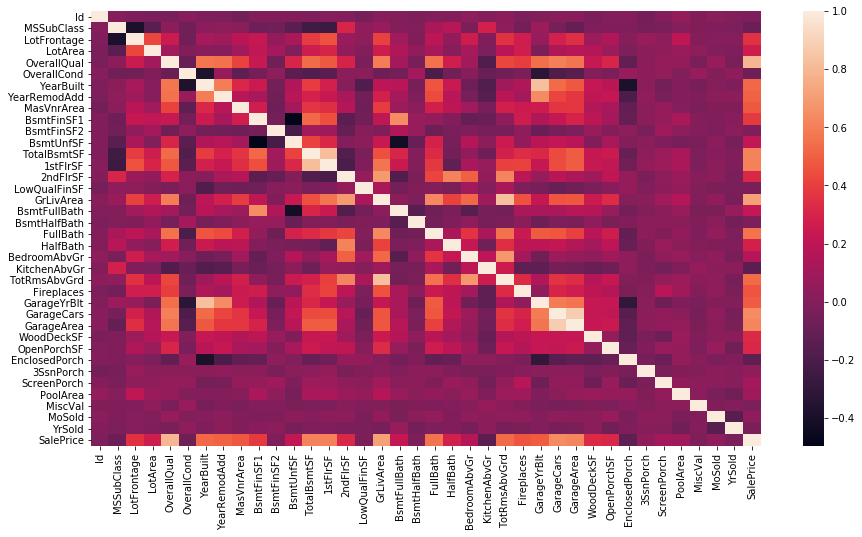

In [44]:
#plot the heatmap to check for correlations
plt.figure(figsize=(15,8))
sns.heatmap(train.corr())

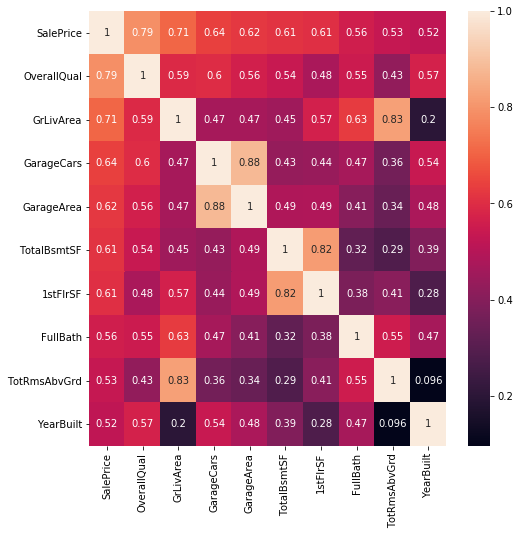

In [45]:
#check the top 10 correlations with Sale Price
cols = train.corr().nlargest(10, 'SalePrice')['SalePrice'].index

plt.figure(figsize=(8,8))
sns.heatmap(train[cols].corr(),annot=True)

# Data cleaning and featuring 

In [46]:
#check for null
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [47]:
#Filling null value
train['MiscFeature'].fillna('Non',inplace=True)
train['Alley'].fillna('Non',inplace=True)
train['Fence'].fillna('Non',inplace=True)
train['FireplaceQu'].fillna('Non',inplace=True)
train['PoolQC'].fillna('Non',inplace=True)
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train['Electrical']=train['Electrical'].fillna(train['Electrical'].mode()[0])

#fill null value in the LotFrontage variable
train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#fill null value in the Garage variables
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    
train['GarageYrBlt']=train.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x:x.fillna(x.median()))

#fill null value in the Bsmt variables
for col in ('BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1','BsmtCond'):
    train[col] = train[col].fillna('None')

In [48]:
#Remove outliers in GrLiveArea
train.sort_values(by='GrLivArea',ascending = False)[0:2] #look for id of outliers and drop them

train.drop(train[train['Id'] == 1299].index,inplace=True)
train.drop(train[train['Id'] == 524].index,inplace=True)

In [49]:
#transform the variable to logarithm
train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = np.log1p(train[skewed_feats])

In [51]:
#check the train data again
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110874,RL,4.189655,9.042040,Pave,Non,Reg,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,2,2008,WD,Normal,12.247699
1,2,3.044522,RL,4.394449,9.169623,Pave,Non,Reg,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,5,2007,WD,Normal,12.109016
2,3,4.110874,RL,4.234107,9.328212,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,9,2008,WD,Normal,12.317171
3,4,4.262680,RL,4.110874,9.164401,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,2,2006,WD,Abnorml,11.849405
4,5,4.110874,RL,4.442651,9.565284,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,12,2008,WD,Normal,12.429220


In [53]:
#import test data
test= pd.read_csv('test.csv')

Do the same cleaning steps in train data to test data

In [55]:
#check for null in test
test.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

In [56]:
#cleaning the test data
test['MiscFeature'].fillna('Non',inplace=True)
test['Alley'].fillna('Non',inplace=True)
test['Fence'].fillna('Non',inplace=True)
test['FireplaceQu'].fillna('Non',inplace=True)
test['PoolQC'].fillna('Non',inplace=True)

test['LotFrontage']=test.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')
test['GarageYrBlt']=test.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x:x.fillna(x.median()))

for col in ('BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1','BsmtCond'):
    test[col] = test[col].fillna('None')
    
test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)
test['MSZoning']=test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Functional']=test['Functional'].fillna('Typ')
test=test.drop(['Utilities'],axis=1)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)
    
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

for col in ('GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)

test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

In [57]:
#transform to logarithm
numeric_feats_test = test.dtypes[test.dtypes != "object"].index

skewed_feats_test = test[numeric_feats_test].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats_test = skewed_feats_test[skewed_feats_test > 0.75]
skewed_feats_test = skewed_feats_test.index

test[skewed_feats_test] = np.log1p(test[skewed_feats_test])

# Modeling

In [58]:
#Merge test and train data into one
all_data = pd.concat((train, test)).reset_index(drop=True)

In [60]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110874,RL,4.189655,9.042040,Pave,Non,Reg,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,2,2008,WD,Normal,12.247699
1,2,3.044522,RL,4.394449,9.169623,Pave,Non,Reg,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,5,2007,WD,Normal,12.109016
2,3,4.110874,RL,4.234107,9.328212,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,9,2008,WD,Normal,12.317171
3,4,4.262680,RL,4.110874,9.164401,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,2,2006,WD,Abnorml,11.849405
4,5,4.110874,RL,4.442651,9.565284,Pave,Non,IR1,Lvl,AllPub,...,0.0,Non,Non,Non,0.0,12,2008,WD,Normal,12.429220


In [61]:
all_data = pd.get_dummies(all_data)
test_dummies = all_data[all_data['SalePrice'].isnull()]
train_dummies = all_data[all_data['SalePrice'].notnull()]

In [62]:
X_train = train_dummies.drop(['SalePrice'],axis=1)
X_test = test_dummies.drop(['SalePrice'],axis=1)
y = train_dummies['SalePrice']

In [63]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [64]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [65]:
model_ridge = Ridge()

In [66]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

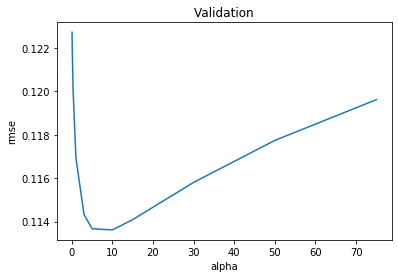

In [67]:
#plot the mse and alpha
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [68]:
cv_ridge.min()

0.11361838023901574

In [69]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

In [70]:
rmse_cv(model_lasso).mean()

0.11026214709195777

In [72]:
#get the prediction
pred =np.expm1(model_lasso.predict(X_test))

In [ ]:
#export the prediction to csv file for submission 
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)